## Check GPU

---

In [0]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.device('/gpu:0'):
  random_image_gpu = tf.random_normal((100, 100, 100, 3))
  net_gpu = tf.layers.conv2d(random_image_gpu, 32, 7)
  net_gpu = tf.reduce_sum(net_gpu)
  
sess = tf.Session(config=config)

try:
  sess.run(tf.global_variables_initializer())
  print('ok')
except tf.errors.InvalidArgumentError:
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
ok


## Connect to the Google Drive

---



In [0]:
from os.path import join
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT)

PROJ = "My Drive/practice/tensorflow_object_detection_api/TFConfig" # This is a custom path.
PROJECT_PATH = join(ROOT, PROJ)

%cd ~/content
%cd drive/My Drive/practice/tensorflow_object_detection_api/TFConfig

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
[Errno 2] No such file or directory: '/root/content'
/content
/content/drive/My Drive/practice/tensorflow_object_detection_api/TFConfig


## Clone Git repo

---



In [0]:
!git clone https://github.com/dodandeniya/TFmodels.git

fatal: destination path 'TFmodels' already exists and is not an empty directory.


## Compiling

---



In [0]:
%cd ~
%cd /content
%cd drive/My Drive/practice/tensorflow_object_detection_api/TFConfig/TFmodels/research
!pwd
!protoc object_detection/protos/*.proto --python_out=.

/root
/content
/content/drive/My Drive/practice/tensorflow_object_detection_api/TFConfig/TFmodels/research
/content/drive/My Drive/practice/tensorflow_object_detection_api/TFConfig/TFmodels/research


## Test object detection

---

In [0]:
%cd ~
%cd /content
%cd drive/My Drive/practice/tensorflow_object_detection_api/TFConfig/
import os
os.environ['PYTHONPATH'] += ':/content/drive/My Drive/practice/tensorflow_object_detection_api/TFConfig/TFmodels/research/:/content/drive/My Drive/TFConfig/TFmodels/research/slim/'
os.environ['PYTHONPATH'] += ':/content/drive/My Drive/practice/tensorflow_object_detection_api/TFConfig/TFmodels/research/:/content/drive/My Drive/TFConfig/TFmodels/research/object_detection/'
!python TFmodels/research/object_detection/builders/model_builder_test.py

# Change the directory path

%cd TFmodels/research/object_detection

/root
/content
/content/drive/My Drive/practice/tensorflow_object_detection_api/TFConfig
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Traceback (most recent call last):
  File "TFmodels/research/object_detection/builders/model_builder_test.py", line 23, in <module>
    from object_detection.builders import model_builder
  File "/content/drive/My Drive/practice/tensorflow_object_detection_api/TFConfig/TFmodels/research/object_detection/builders/model_builder.py", line 35, in <module>
    from object_detection.models import faster_rcnn_inception_resnet_v2_feature_extractor as frcnn_inc_res
  File "/content/drive/My Drive/practice/tensorflow_object_detection_api/TFConfig/TFmo

## Run script

---



In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')
  
%matplotlib inline

from utils import label_map_util

from utils import visualization_utils as vis_util



In [0]:
# Model preparation

# What model to download.
MODEL_NAME = 'faster_rcnn_resnet101_coco_2018_01_28'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = '/content/drive/My Drive/practice/tensorflow_object_detection_api/TFConfig/TFmodels/research/object_detection/' + MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/content/drive/My Drive/practice/tensorflow_object_detection_api/TFConfig/TFmodels/research/object_detection/data', 'mscoco_label_map.pbtxt')
# change to  path to label to mscoco_label_map.pbtxt for coco

In [0]:
# Download Model

opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())
    

In [0]:
# Load a (frozen) Tensorflow model into memory.

detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    

In [0]:
# Loading label map

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

#Helper code

def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [0]:
# Detection ----------------------------------------------------------------



# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/content/drive/My Drive/practice/tensorflow_object_detection_api/TFConfig/TFmodels/research/object_detection/test_images/'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(3, 4) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
          
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
      

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})
      

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]


      #Manipulation for detecting only one class (17 : Cat)
      count=0
      list=[]
      for i in output_dict['detection_classes']:
        count=count+1
        if i==17:
          list.append(count)
      number=len(list)       


      count=0
      arraylist=[]
      for x in output_dict['detection_scores']:
        count=count+1
        for y in list:
          if y==count:
            arraylist.append(output_dict['detection_scores'][count-1])

      scores_array=np.array(arraylist)
      output_dict['detection_scores']=scores_array

      count=0
      arraylist=[]
      for x in output_dict['detection_boxes']:
        count=count+1
        for y in list:
          if y==count:
            arraylist.append(output_dict['detection_boxes'][count-1])

      boxes_array=np.array(arraylist)
      output_dict['detection_boxes']= boxes_array

      count=0
      arraylist=[]
      for x in output_dict['detection_classes']:
        count=count+1
        for y in list:
          if y==count:
            arraylist.append(output_dict['detection_classes'][count-1])

      classes_array=np.array(arraylist)
      output_dict['detection_classes']= classes_array

      
        
        
  return output_dict

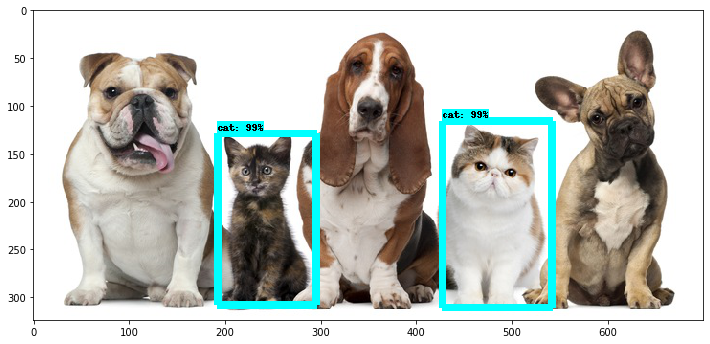

In [0]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)